## Softmax MNIST Classification Problem
### The main task was to learn the basic structure of TensorFlow and Keras.

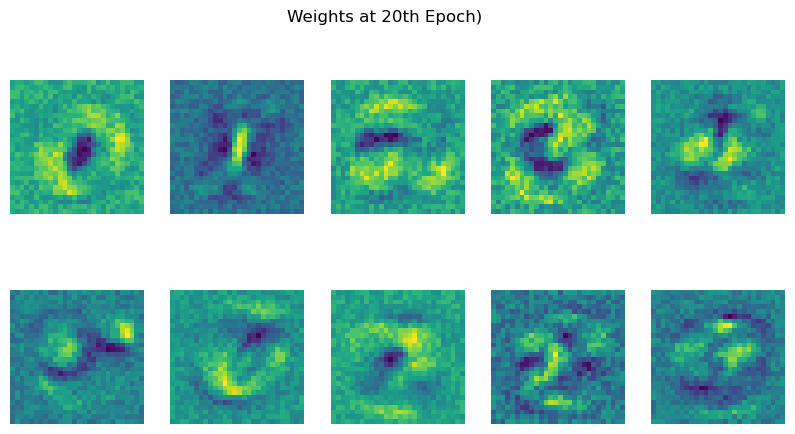

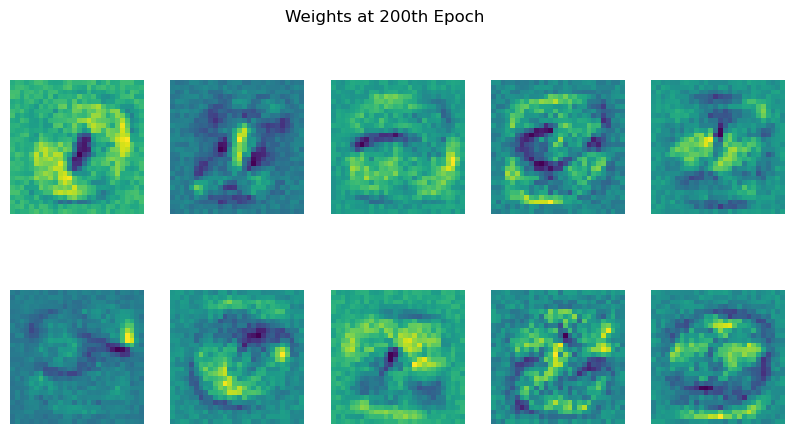

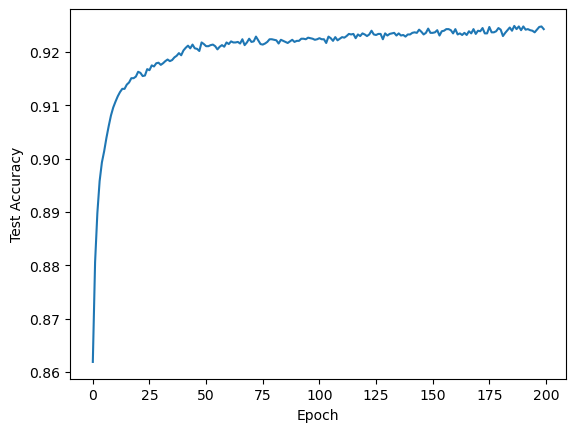

In [16]:
#Question 1
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# Load mnist data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255

# Structure only using softmax(one layer)
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    #layers.Dense(100, activation='sigmoid')
    layers.Dense(10, activation='softmax')])#one hot lebel vector

# Gradient and loss function
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Make a ModelCheckpoint callbacks and set the period 20(20,40,60...200)
model_checkpoint = callbacks.ModelCheckpoint(
    filepath='weights_at_{epoch:03d}.h5', save_weights_only=True, period=20)

#fitting with callbacks
history = model.fit(train_input, train_target, epochs=200, verbose=0,
                    validation_data=(test_input, test_target),callbacks=[model_checkpoint],batch_size = 64)

# Load weights and reshape
model.load_weights('weights_at_020.h5')
weights_20th_epoch = model.layers[1].get_weights()[0]
weights_20th_epoch = weights_20th_epoch.reshape((28, 28, 10))

model.load_weights('weights_at_200.h5')
weights_200th_epoch = model.layers[1].get_weights()[0]
weights_200th_epoch = weights_200th_epoch.reshape((28, 28, 10))

# Weights Plot
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights_20th_epoch[:, :, i])
    plt.axis('off')
plt.suptitle('Weights at 20th Epoch)')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights_200th_epoch[:, :, i])
    plt.axis('off')
plt.suptitle('Weights at 200th Epoch')
plt.show()

# Accuracy Plot
test_accuracy = history.history['val_accuracy']
plt.figure()
plt.plot(test_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.show()

## Autoencoder-Based Feature Learning Problem
### This is a problem that took me a lot of trial and error over several days. However, the graph for H activation was not at a level that I was satisfied with. However, there was a clear difference in H activation between adding sparsity and naive.

313/313 [==============================] - 1s 2ms/step - loss: 0.0061
MSE Loss: 0.006090458948165178


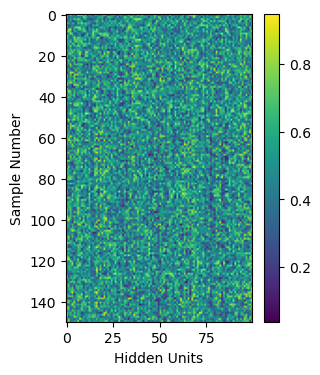

1/1 [==============================] - 0s 55ms/step


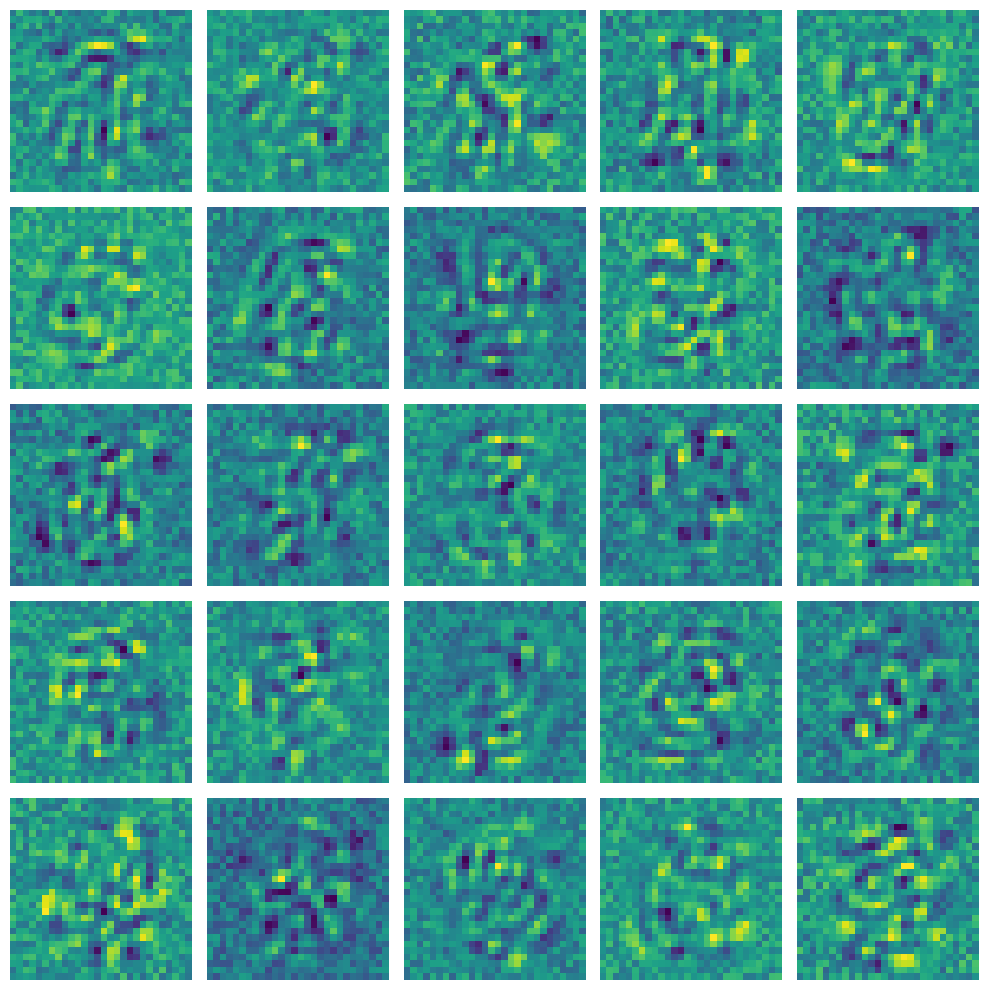

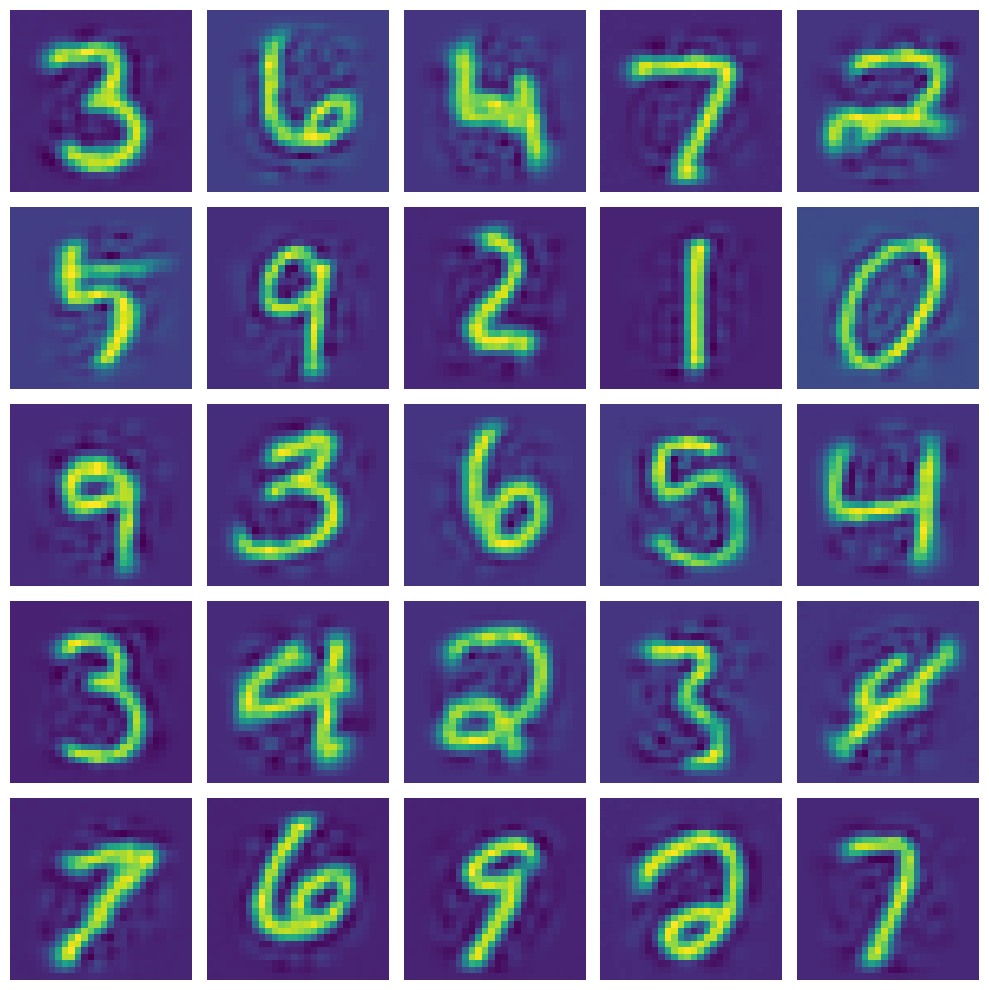

In [41]:
#Question 2-1
# Naive
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load mnist data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255

#Make encoder structure
naive_encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid')])

naive_decoder = models.Sequential([
    layers.Dense((28*28),activation = None),
    layers.Reshape((28, 28))])

AE = models.Sequential([naive_encoder, naive_decoder])

#Compile
AE.compile(loss='mean_squared_error', 
           optimizer=tf.keras.optimizers.SGD(learning_rate=0.3))

#Fitting
history = AE.fit(train_input, train_input, epochs=200, verbose=0,  
                 validation_data=(test_input, test_input), batch_size=16)


# Evaluate MSE 
mse_loss = AE.evaluate(test_input, test_input)

# Print MSE
print("MSE Loss:", mse_loss)

# best MSE loss
best_loss = 0.0  # Initialize with a large value
if mse_loss < best_loss or best_loss == 0:
    best_loss = mse_loss
    # Save the weights
    naive_hidden_weights = naive_encoder.layers[1].get_weights()[0]
    naive_hidden_bias = naive_encoder.layers[1].get_weights()[1]
    np.save('naive_hidden_weights.npy', naive_hidden_weights)
    np.save('naive_hidden_bias.npy', naive_hidden_bias)
    
          
    
# Load the weights&bias    
sample_inputs = train_input[-150:]
naive_hidden_weights = np.load('naive_hidden_weights.npy')
naive_hidden_bias = np.load('naive_hidden_bias.npy')

#activations = naive_encoder.predict(train_input[-150:])
#sample_input = sample_input.reshape(-1, 784)
#activations = AE.predict(sample_inputs)
#subset_input = train_input[:150]
#activations = naive_encoder.predict(subset_input)
activations = tf.sigmoid((sample_inputs.reshape(-1, 28 * 28)@naive_hidden_weights)+naive_hidden_bias)

# Create a heatmap to visualize the activations
plt.figure(figsize=(3, 4))
plt.imshow(activations, aspect='auto')
plt.colorbar()
plt.xlabel('Hidden Units')
plt.ylabel('Sample Number')
plt.show()



# 25 random weights visualization
random_weights_indices = np.random.choice(naive_hidden_weights.shape[1], size=25, replace=False)

plt.figure(figsize=(10, 10))
for i, index in enumerate(random_weights_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(naive_hidden_weights[:,index].reshape(28, 28))
    plt.axis('off')
plt.tight_layout()



# 25 random reconstructed images visualization
random_images_indices = np.random.choice(len(test_input), size=25, replace=False)
random_images = test_input[random_images_indices]
recon_images = AE.predict(random_images)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(recon_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 2ms/step - loss: 0.0081
MSE Loss: 0.008057988248765469


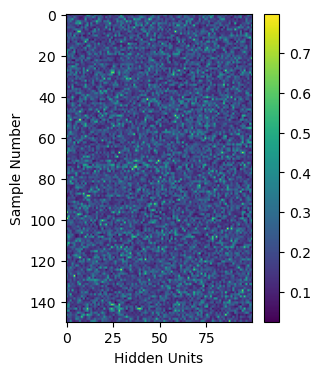

1/1 [==============================] - 0s 75ms/step


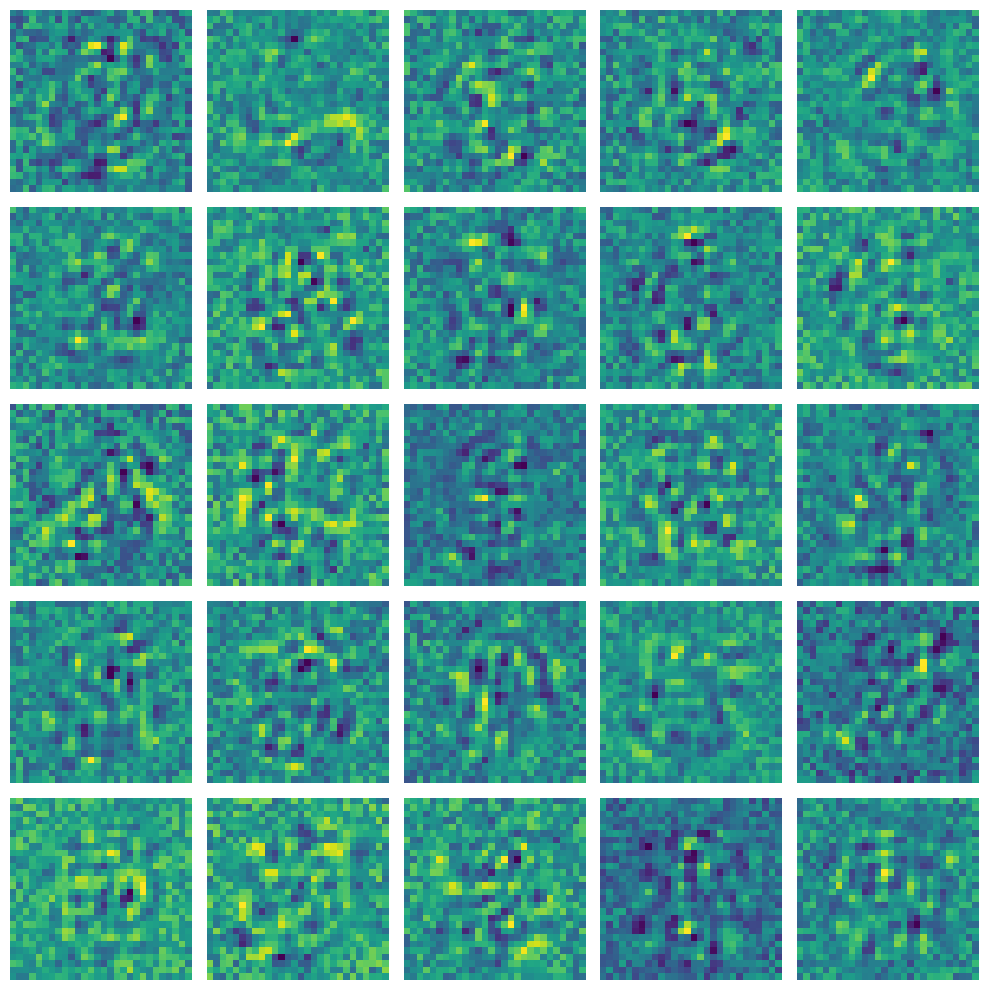

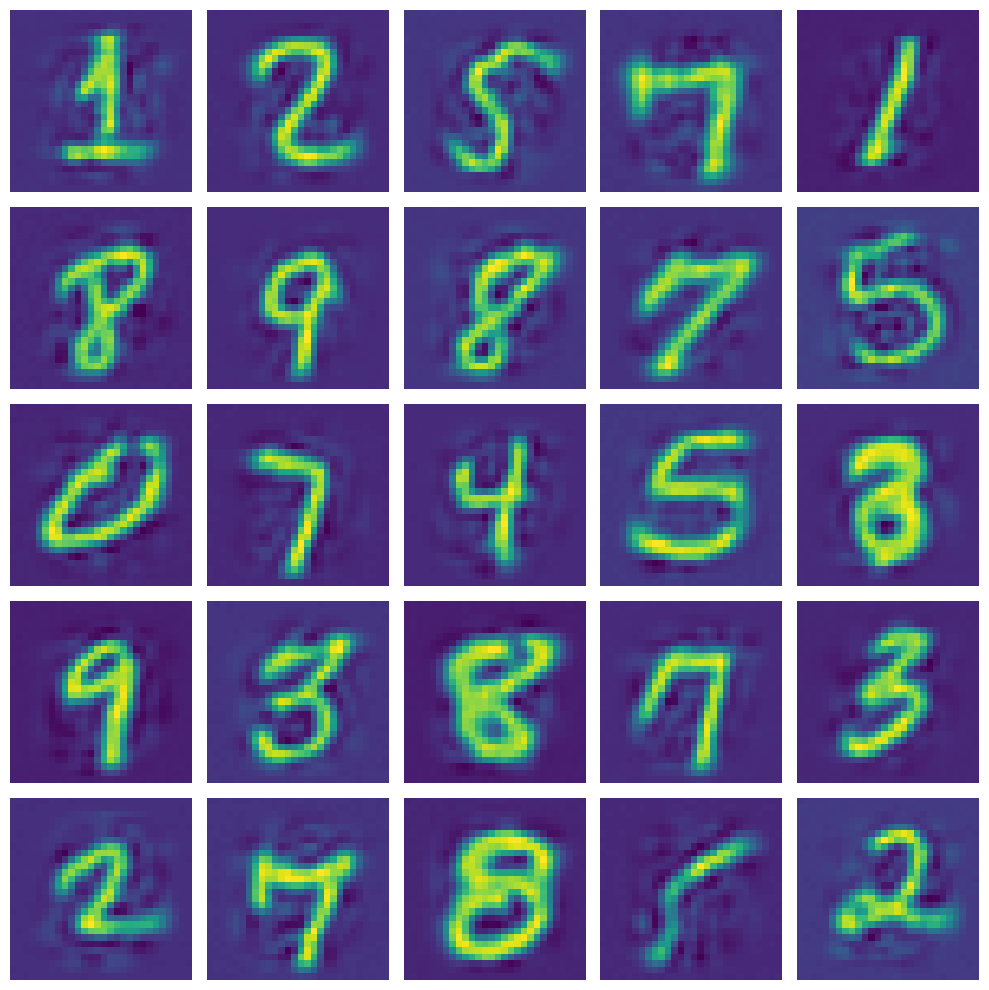

In [44]:
#Question 2-2
#sparse
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import callbacks
import random
import tensorflow.keras as keras

# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255

# KLDivergenceRegularizer_ver1
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, lamd=0.1, alpha=0.2):
        self.lamd = lamd
        self.alpha = alpha

    def __call__(self, inputs):
        alpha_hat = tf.reduce_mean(inputs, axis=0) #np.mean(inputs, axis=0)
        kl_divergence = tf.reduce_sum(
            self.alpha * tf.math.log(self.alpha / alpha_hat) +
            (1 - self.alpha) * tf.math.log((1 - self.alpha) / (1 - alpha_hat)))
        return self.lamd * kl_divergence
    
    def get_config(self):
        return {'lamd': self.lamd, 'alpha': self.alpha}

    

# KLDivergenceRegularizer_ver2    
#K = keras.backend
#kl_divergence = keras.losses.kullback_leibler_divergence

#class KLDivergenceRegularizer(keras.regularizers.Regularizer):
#    def __init__(self, lamd, alpha=0.2):
#        self.lamd = lamd
#        self.alpha = alpha

#    def __call__(self, inputs):
#        mean_activities = K.mean(inputs, axis =0)
#        return self.lamd * (
#            kl_divergence(self.alpha, mean_activities) +
#            kl_divergence(1 - self.alpha, 1 - mean_activities))
#    
#    def get_config(self):
#        return {'lamd': self.lamd, 'alpha': self.alpha}

kld_reg = KLDivergenceRegularizer(lamd=0.1, alpha=0.2)



#Make encoder structure with KL
sparse_encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid', activity_regularizer=kld_reg)])

sparse_decoder = models.Sequential([
    layers.Dense((28*28),activation = None),
    layers.Reshape((28, 28))])

SE = models.Sequential([sparse_encoder, sparse_decoder])

#Compile
SE.compile(loss='mean_squared_error', 
           optimizer=tf.keras.optimizers.SGD(learning_rate=0.3))

#Fitting
history = SE.fit(train_input, train_input, epochs=200, verbose=0,  
                 validation_data=(test_input, test_input), batch_size=16)#callbacks=[sparse_checkpoint])


# Evaluate MSE 
sparse_mse_loss = SE.evaluate(test_input, test_input)

# Print MSE
print("MSE Loss:", sparse_mse_loss)

# Best MSE loss
best_loss = 0.0  # Initialize with a large value
if sparse_mse_loss < best_loss or best_loss == 0:
    best_loss = sparse_mse_loss
    # Save the weights
    sparse_hidden_weights = sparse_encoder.layers[1].get_weights()[0]
    sparse_hidden_bias = sparse_encoder.layers[1].get_weights()[1]
    np.save('sparse_hidden_weights.npy', sparse_hidden_weights)
    np.save('sparse_hidden_bias.npy', sparse_hidden_bias)
    
    

# Load the weights&bias    
sample_inputs = train_input[-150:]
sparse_hidden_weights = np.load('sparse_hidden_weights.npy')
sparse_hidden_bias = np.load('sparse_hidden_bias.npy')

np.random.seed(42)
random_indices = np.random.choice(test_input.shape[0], 150, replace=False)
sample_inputs = test_input[random_indices]

# Get activations
activations = tf.sigmoid(tf.matmul(sample_inputs.reshape(-1, 28 * 28), sparse_hidden_weights)+sparse_hidden_bias)



# Create a activation heatmap
plt.figure(figsize=(3, 4))
plt.imshow(activations, aspect='auto')
plt.colorbar()
plt.xlabel('Hidden Units')
plt.ylabel('Sample Number')
plt.show()



# 25 random weights visualization
random_weights_indices = np.random.choice(sparse_hidden_weights.shape[1], size=25, replace=False)

plt.figure(figsize=(10, 10))
for i, index in enumerate(random_weights_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sparse_hidden_weights[:,index].reshape(28, 28))
    plt.axis('off')
plt.tight_layout()



# 25 random reconstructed images visualization
random_images_indices = np.random.choice(len(test_input), size=25, replace=False)
random_images = test_input[random_images_indices]
recon_images = SE.predict(random_images)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(recon_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

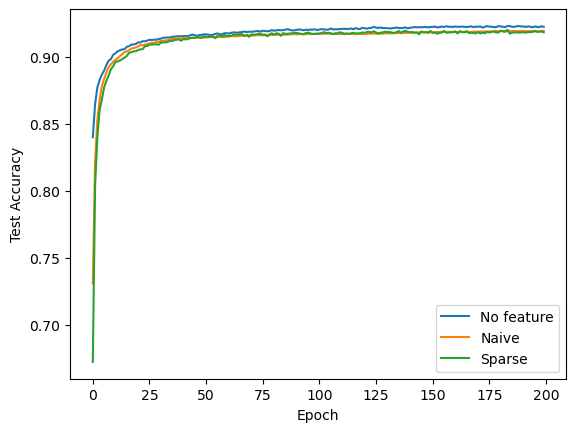

In [50]:
#Question 2-3
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

#Custom train model
def train_model(model, train_input, train_target, test_input, test_target):
    # Compile
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Fitting 
    history = model.fit(train_input, train_target, epochs=200, verbose=0,
                        validation_data=(test_input, test_target),batch_size=120)

    return history.history['val_accuracy']



# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255


# Make a structure only using softmax (one layer) - No feature
model_no_feature = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(10, activation='softmax')])  # one-hot label vector

# Train No Feature Model
test_accuracy_no_feature = train_model(model_no_feature, train_input, train_target, test_input, test_target)




# Load the weights from the file - Naive
loaded_weights_naive = np.load('naive_hidden_weights.npy')
loaded_bias_naive = np.load('naive_hidden_bias.npy')

# Make a structure using softmax - Naive
model_naive = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation = None, use_bias=True, trainable=False),
    layers.Dense(10, activation='softmax')]) 
# Set the weights for the first Dense layer
model_naive.layers[1].set_weights([loaded_weights_naive, loaded_bias_naive])

# Train Naive Model
test_accuracy_naive = train_model(model_naive, train_input, train_target, test_input, test_target)




# Load the weights from the file - Sparse
loaded_weights_sparse = np.load('sparse_hidden_weights.npy')
loaded_bias_sparse = np.load('sparse_hidden_bias.npy')

# Make a structure using softmax - Sparse
model_sparse = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100 ,activation = None, use_bias=True, trainable=False),
    layers.Dense(10, activation='softmax')]) 

# Set the weights for the first Dense layer
model_sparse.layers[1].set_weights([loaded_weights_sparse, loaded_bias_sparse])

# Train Sparse Model
test_accuracy_sparse = train_model(model_sparse, train_input, train_target, test_input, test_target)




# 3 model plot
plt.figure()
plt.plot(test_accuracy_no_feature, label='No feature')
plt.plot(test_accuracy_naive, label='Naive')
plt.plot(test_accuracy_sparse, label='Sparse')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

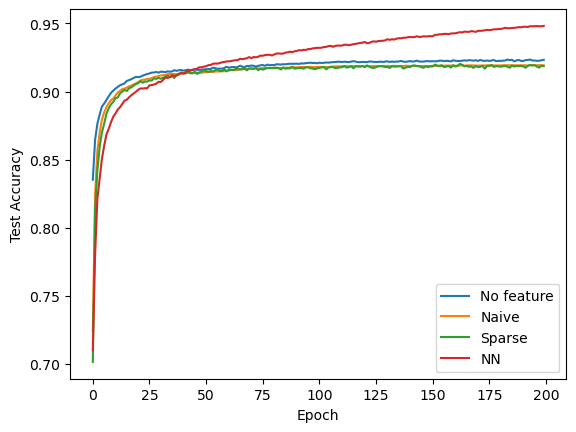

In [52]:
#Question 2-4
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, train_input, train_target, test_input, test_target):
    # Compile
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    #Fitting
    history = model.fit(train_input, train_target, epochs=200, verbose=0,
                        validation_data=(test_input, test_target),batch_size=120)

    return history.history['val_accuracy']



# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255




# Make a structure only using softmax (one layer) - No feature
model_no_feature = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(10, activation='softmax')])  # one-hot label vector

# Train No Feature Model
test_accuracy_no_feature = train_model(model_no_feature, train_input, train_target, test_input, test_target)




# Load the weights from the file - Naive
loaded_weights_naive = np.load('naive_hidden_weights.npy')
loaded_bias_naive = np.load('naive_hidden_bias.npy')

# Make a structure using softmax - Naive
model_naive = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation = None, use_bias=True, trainable=False),
    layers.Dense(10, activation='softmax')]) 
# Set the weights for the first Dense layer
model_naive.layers[1].set_weights([loaded_weights_naive, loaded_bias_naive])

# Train Naive Model
test_accuracy_naive = train_model(model_naive, train_input, train_target, test_input, test_target)




# Load the weights from the file - Sparse
loaded_weights_sparse = np.load('sparse_hidden_weights.npy')
loaded_bias_sparse = np.load('sparse_hidden_bias.npy')

# Make a structure using softmax - Sparse
model_sparse = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100 ,activation = None, use_bias=True, trainable=False),
    layers.Dense(10, activation='softmax')]) 

# Set the weights for the first Dense layer
model_sparse.layers[1].set_weights([loaded_weights_sparse, loaded_bias_sparse])

# Train Sparse Model
test_accuracy_sparse = train_model(model_sparse, train_input, train_target, test_input, test_target)




# Make a NN structure
model_nn = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(10, activation='softmax')])  

# Train NN Model - NN
test_accuracy_nn = train_model(model_nn, train_input, train_target, test_input, test_target)

# 4 model plot
plt.figure()
plt.plot(test_accuracy_no_feature, label='No feature')
plt.plot(test_accuracy_naive, label='Naive')
plt.plot(test_accuracy_sparse, label='Sparse')
plt.plot(test_accuracy_nn, label='NN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Shallow Neural Network (Single Hidden Layer) Problem
### I added a layer and enabled backpropagation.

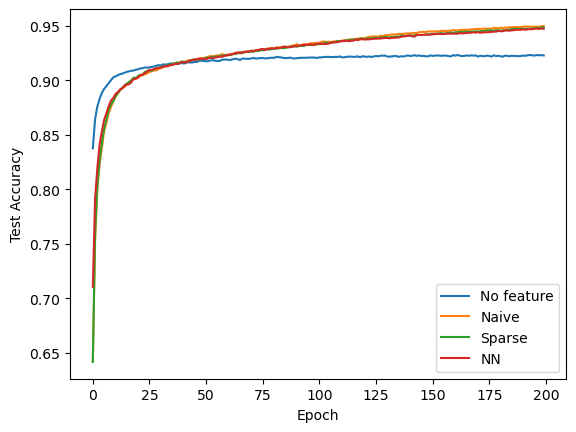

In [56]:
#Question 3
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, train_input, train_target, test_input, test_target):
    # Compile
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),#learning_rate=0.01),
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Fitting
    history = model.fit(train_input, train_target, epochs=200, verbose=0,
                        validation_data=(test_input, test_target),batch_size=120)

    return history.history['val_accuracy']



# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255




# Make a structure only using softmax (one layer) - No feature
model_no_feature = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(10, activation='softmax')])  # one-hot label vector

# Train No Feature Model
test_accuracy_no_feature = train_model(model_no_feature, train_input, train_target, test_input, test_target)





# Load the weights from the file - Naive
loaded_weights_naive = np.load('naive_hidden_weights.npy')

# Make a structure using softmax (one layer) with a hidden layer - Naive
model_naive = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(10, activation='softmax')]) 
# Set the weights for the first Dense layer
model_naive.layers[1].set_weights([loaded_weights_naive, model_naive.layers[1].get_weights()[1]])

# Train Naive Model
test_accuracy_naive = train_model(model_naive, train_input, train_target, test_input, test_target)





# Load the weights from the file - Sparse
loaded_weights_sparse = np.load('sparse_hidden_weights.npy')

# Make a structure using softmax (one layer) with a hidden layer - Sparse
model_sparse = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(10, activation='softmax')]) 

# Set the weights for the first Dense layer
model_sparse.layers[1].set_weights([loaded_weights_sparse, model_sparse.layers[1].get_weights()[1]])

# Train Sparse Model
test_accuracy_sparse = train_model(model_sparse, train_input, train_target, test_input, test_target)





# Make a NN structure
model_nn = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(100, activation='sigmoid'),
    layers.Dense(10, activation='softmax')])  

# Train NN Model - NN
test_accuracy_nn = train_model(model_nn, train_input, train_target, test_input, test_target)

# 4 model plot(ver2)
plt.figure()
plt.plot(test_accuracy_no_feature, label='No feature')
plt.plot(test_accuracy_naive, label='Naive')
plt.plot(test_accuracy_sparse, label='Sparse')
plt.plot(test_accuracy_nn, label='NN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

## Full Backpropagation on Deep Layers (Init & BN Experiments)
### Finding the right structure and learning rate was the main task.

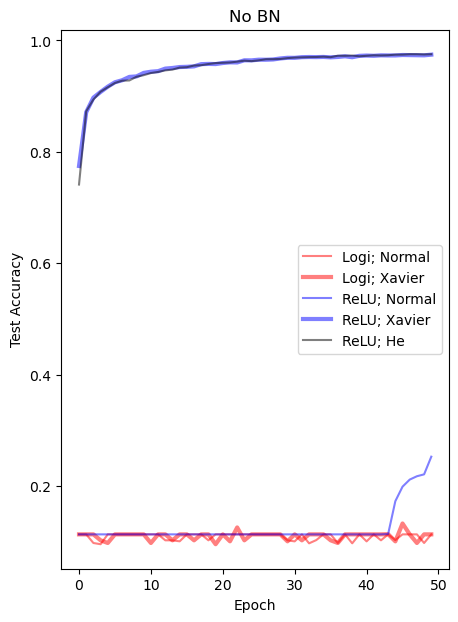

In [53]:
#Question 4-1
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, train_input, train_target, test_input, test_target): 
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),#learning_rate=0.01),
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_input, train_target, epochs=50, verbose=0,
                        validation_data=(test_input, test_target),batch_size=128)

    return history.history['val_accuracy']


# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255


# Set MU and Alpha
def custom_initializer(shape, dtype=None):
    mu = 0.0  
    alpha = 0.01  
    return tf.random.normal(shape, mean=mu, stddev=alpha, dtype=dtype)


# Logistic Normal
model_Logi_Normal = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        Dense(10, activation='softmax')])

test_accuracy_Logi_Normal = train_model(model_Logi_Normal, train_input, train_target, test_input, test_target)


# Logistic Xavier (glorot_normal)
model_Logi_Xavier = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        Dense(10, activation='softmax')])

test_accuracy_Logi_Xavier = train_model(model_Logi_Xavier, train_input, train_target, test_input, test_target)


# ReLU Normal
model_ReLU_Normal = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_Normal = train_model(model_ReLU_Normal, train_input, train_target, test_input, test_target)

# ReLU Xavier
model_ReLU_Xavier = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_Xavier = train_model(model_ReLU_Xavier, train_input, train_target, test_input, test_target)

# ReLU He (VarianceScaling())
model_ReLU_He =tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_He = train_model(model_ReLU_He, train_input, train_target, test_input, test_target)

# Plot results
plt.figure(figsize=(5, 7))
plt.plot(test_accuracy_Logi_Normal, label='Logi; Normal', color = 'red', alpha = 0.5)
plt.plot(test_accuracy_Logi_Xavier, label='Logi; Xavier', color = 'red', alpha = 0.5, linewidth = 3)
plt.plot(test_accuracy_ReLU_Normal, label='ReLU; Normal', color = 'blue', alpha = 0.5)
plt.plot(test_accuracy_ReLU_Xavier, label='ReLU; Xavier', color = 'blue', alpha = 0.5, linewidth = 3)
plt.plot(test_accuracy_ReLU_He,     label='ReLU; He',     color = 'black', alpha = 0.5)
plt.title('No BN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

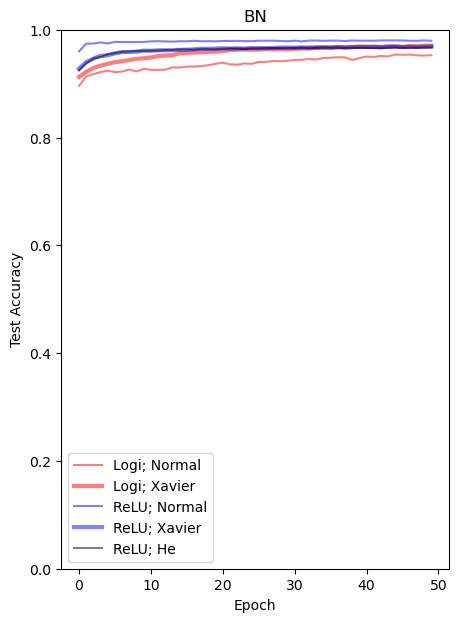

In [55]:
#Question 4-2
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, BatchNormalization
import random
import matplotlib.pyplot as plt

def train_model(model, train_input, train_target, test_input, test_target):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),#learning_rate=0.01),
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_input, train_target, epochs=50, verbose=0,
                        validation_data=(test_input, test_target),batch_size=128)

    return history.history['val_accuracy']


# Load data
mnist = tf.keras.datasets.mnist
(train_input, train_target), (test_input, test_target) = mnist.load_data()

# Normalization
train_input = train_input / 255
test_input = test_input / 255


# Set MU and Alpha
def custom_initializer(shape, dtype=None):
    mu = 0.0  
    alpha = 0.01  
    return tf.random.normal(shape, mean=mu, stddev=alpha, dtype=dtype)


# Logistic Normal
model_Logi_Normal = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')])

test_accuracy_Logi_Normal = train_model(model_Logi_Normal, train_input, train_target, test_input, test_target)


# Logistic Xavier
model_Logi_Xavier = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='sigmoid', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')])

test_accuracy_Logi_Xavier = train_model(model_Logi_Xavier, train_input, train_target, test_input, test_target)


# ReLU Normal
model_ReLU_Normal = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=custom_initializer),
        keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_Normal = train_model(model_ReLU_Normal, train_input, train_target, test_input, test_target)

# ReLU Xavier
model_ReLU_Xavier = tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer='glorot_normal'),
        keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_Xavier = train_model(model_ReLU_Xavier, train_input, train_target, test_input, test_target)

# ReLU He
model_ReLU_He =tf.keras.Sequential([
        Flatten(input_shape=(28, 28)),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        keras.layers.BatchNormalization(),
        Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling()),
        keras.layers.BatchNormalization(),
        Dense(10, activation='softmax')])

test_accuracy_ReLU_He = train_model(model_ReLU_He, train_input, train_target, test_input, test_target)

# Plot results
plt.figure(figsize=(5, 7))
plt.plot(test_accuracy_Logi_Normal, label='Logi; Normal', color = 'red', alpha = 0.5)
plt.plot(test_accuracy_Logi_Xavier, label='Logi; Xavier', color = 'red', alpha = 0.5, linewidth = 3)
plt.plot(test_accuracy_ReLU_Normal, label='ReLU; Normal', color = 'blue', alpha = 0.5)
plt.plot(test_accuracy_ReLU_Xavier, label='ReLU; Xavier', color = 'blue', alpha = 0.5, linewidth = 3)
plt.plot(test_accuracy_ReLU_He,     label='ReLU; He',     color = 'black', alpha = 0.5)
plt.title('BN')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.show()